# Calibration Procedure

* Compute center offset:
 - Set $\lambda_{\rm center}$ to set of known spectral lines
 - Measure pixel position of each: 
 - average each to determine central pixel $n_o$
 
|   $\lambda_{\rm center}$ | Pixel |           
| ----------------------:  |:------:|
| 0   nm                   | 5.2 | 
| 445 nm                   | 6.22      |  
| 901 nm                   | 3.1      | 


 
* Compute spectrometer calibration angles/length ($\ f_L, \delta, \gamma$)
 * Move known spectral line $\lambda_o$ to left and right sides of detector
 * record $\lambda_{\rm center}$ and pixel position for each 
 * Compute best fit of $\ f_{\rm calib}$


| $\lambda_o$   | Side | $\lambda_{\rm center}$| Pixel  |
| ------------- | ---- |:----------------------|-------:|
| 809.4 nm      | R    |729.4910 nm            |508     |
| 809.4 nm      | L    |899.5830 nm            |  4     |
| ...           | ...  | ...                   |...     |



# Optimization Function

Optimize for 3 parameters:
 * $f_L$: Focal length of spectrometer
 * $\delta$: Detector angle (The angle of the image plane relative to the plane perpendicular to the spectrograph focal axis at the center of the image plane)
 * $\gamma$: inclusion angle

from experiment:
 * $n =  n_{px} - n_o$: Pixel from central pixel
 * $\lambda_{\rm center}$: Wavelength of center pixel 
 * $\lambda_p$: Wavelength of pixel $n$
 
Fixed Constants:
 * $m$: Diffraction order (typically one)
 * $x_{\rm pixel}$: pixel size
 * $d_{grating}$: Grating pitch (1/(groves / mm))
    
residual: (wl,  wl_p, n, f, delta,gamma)

We measure pixel position ($n$) of a known wavelength ($\lambda_p$) for multple peaks and spectrometer positions and find the best fit parameters $\ f_L, \delta, \gamma$:

$$ \lambda_p = f_{\rm calib} ( n,  \lambda_{\rm center}, 
    \underbrace{m, x_{\rm pixel}, d_{\rm grating}}_{\rm spec\ params}, 
    \overbrace{f_L,\ \ \delta,\ \ \gamma}^{\rm Calibration\ params} ) $$

$$ \lambda_p = \frac{d}{m} \cdot \left[ \sin( \psi - \frac{\gamma}{2}) + \sin(\psi+\frac{\gamma}{2} + \eta) \right]$$

Where

$$ \psi = \arcsin \left[ \frac{ m\ \lambda_{\rm center} } { 2\ d_{\rm grating} \cos(\frac{\gamma}{2})} \right] $$

$$ \eta = \arctan \left[ \frac{ n\ x_{pixel} \cos{\delta}} {f_L + n\ x_{pixel} \sin(\delta)} \right]$$

$$n =  n_{px} - n_o$$



In [514]:
from __future__ import division
import numpy as np
import  matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

%matplotlib notebook

In [515]:
def wl_p_calib_p2(px, n0, offset_adjust, wl_center, m_order, d_grating, x_pixel, f, delta, gamma, curvature):
    #consts
    #d_grating = 1./150. #mm
    #x_pixel   = 16e-3 # mm
    #m_order   = 1 # diffraction order, unitless
    n = px - (n0+offset_adjust*wl_center)# the last term does not make sense because wl_center always > 0 
    #n = px - n0*wl_center + offset_adjust
    psi = np.arcsin( m_order* wl_center / (2*d_grating*np.cos(gamma/2.)))
    eta = np.arctan(n*x_pixel*np.cos(delta) / (f+n*x_pixel*np.sin(delta)))
    
    return ((d_grating/m_order)
                    *(np.sin(psi-0.5*gamma)
                      + np.sin(psi+0.5*gamma+eta))) + curvature*n**2

In [516]:
from scipy.optimize import least_squares,curve_fit

def fit_residual(
                # optimization parameters
                opt_params, #  (f, delta, gamma, curvature)
                # other params and data
                px, n0, offset_adjust, wl_center, m_order, d_grating, x_pixel,
                wl_actual
                ):
    
    (f, delta, gamma, curvature) = opt_params
    wl_model = wl_p_calib_p2(px, n0, offset_adjust, wl_center, m_order, d_grating, x_pixel, f, delta, gamma,curvature)
    return wl_model - wl_actual

def linear(x,a,b):
    return x*a+b

# Andor grating 1 (50 g/mm Bz 600) Side input 05 Dec 2018, focus 295 steps

<IPython.core.display.Javascript object>


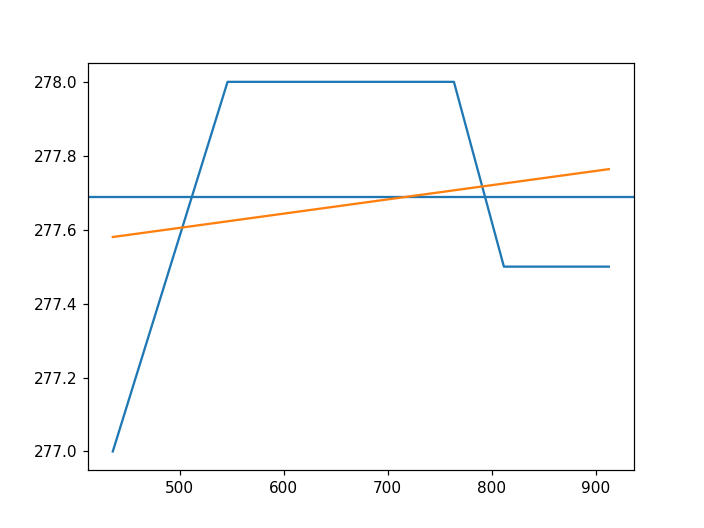

In [522]:
offset = 2
wl_center_data = np.array([
# center_wl, pixel of peak
#[0,     272.0],
#[404.656, 274.],
[435.833, 275.0+offset],
[546.074, 276.0+offset],
[696.543, 276.0+offset],
[706.722, 276.0+offset],
[763.511, 276.0+offset],
[811.532, 275.5+offset],
[842.465, 275.5+offset],
[912.297, 275.5+offset],    
])
x = wl_center_data[:,0]
y = wl_center_data[:,1]
params,cov = curve_fit(linear,x,y)
#n0, offset_adjust = params linear fit

n0 = np.mean(y)
plt.figure()
plt.plot(x,y)
plt.axhline(n0)

plt.plot(x,linear(x,*params))

In [523]:
dispersion_data = np.array([
#wl_actual, wl_center, pixel
[435.833, 235, 483.3+offset],
[435.833, 635, 68.2+offset],
    
[546.074, 346,483+offset],
[546.074, 746,66.9+offset],
  
[696.543, 496, 485+offset],
[696.543, 896, 66+offset],

[579.066, 379, 482.9+offset],
[579.066, 779, 66+offset],
    
[811.532, 611, 486+offset],
[811.532, 1011, 65+offset],

[763.511, 563, 486+offset],
[763.511, 963, 66+offset],

[912.297, 712, 486+offset],
[912.297, 1112, 65+offset]
])

In [525]:
initial_guess = (2.99e8,0.1,0.1,0)  #  (f, delta, gamma, curvature)
bounds = ([2.9e8,-np.inf,-np.inf,-0.1],[3.1e8,np.inf,np.inf,0.1])
kwargs = dict(
    px=dispersion_data[:,2], 
    n0=n0,
    wl_center=dispersion_data[:,1], # nm
    m_order=1,
    d_grating=1/50.*1e6, # nm
    x_pixel=16e3, #nm
    wl_actual=dispersion_data[:,0], # nm
    offset_adjust = 0.
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs,method='trf',bounds=bounds,xtol = 1e-12, gtol = 1e-12)
result.x

array([  2.99000000e+08,  -5.75771579e-04,   8.95142104e-01,
         1.60891760e-05])

<IPython.core.display.Javascript object>


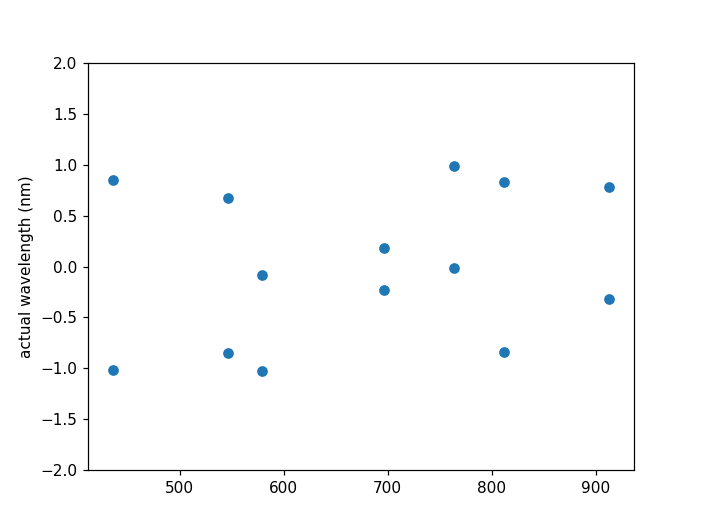

Text(0,0.5,'actual wavelength (nm)')

In [526]:
kwargs = dict(
    px=dispersion_data[:,2], 
    #px=wl_center_data[:,1],
    n0=n0,
    wl_center=dispersion_data[:,1],
    #wl_center=wl_center_data[:,0]*1e-6,
    m_order=1,
    d_grating=1/50.*1e6, # nm
    x_pixel=16e3, #nm
    #wl_actual=dispersion_data[:,0]*1e-6,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    offset_adjust = 0.,
    curvature = result.x[3]
)

wl_p_calib_p2(**kwargs) - dispersion_data[:,0]

plt.figure(4)
plt.plot(dispersion_data[:,0],wl_p_calib_p2(**kwargs) - dispersion_data[:,0],'o')
plt.ylim(-2,2)
plt.ylabel('deviation (nm)')
plt.ylabel('actual wavelength (nm)')

In [527]:
# to store for ini file
# f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature
Y = 'f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature'.split(', ')
str([ kwargs[x] for x in Y ])
#kwargs

'[298999999.70227808, -0.0005757715791466487, 0.8951421038346693, 277.6875, 0.0, 20000.0, 16000.0, 1.6089176010887869e-05]'

# Andor grating 2 (150 g/mm Bz) 05 Dec 2018, focus 295 steps

<IPython.core.display.Javascript object>


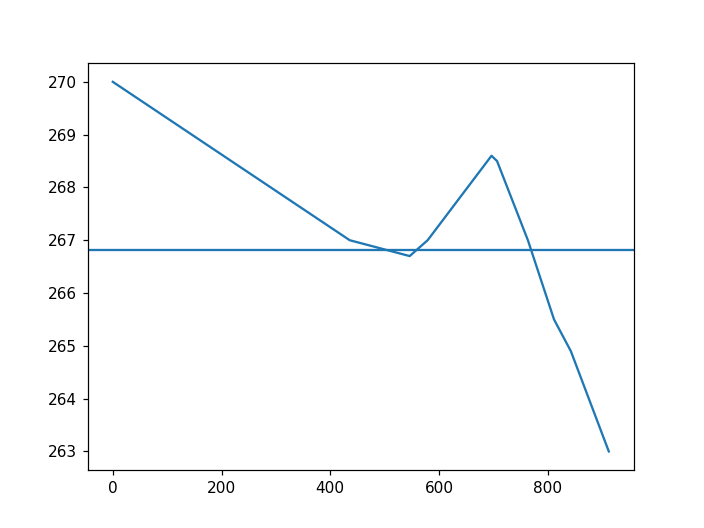

In [471]:
# Camera focus = 410 steps
wl_center_data = np.array([
# center_wl, pixel of peak
[0,     270],
[435.833, 267],
[546.074, 266.7],
[579.066, 267.0],
[696.543, 268.6],
[706.722, 268.5],
[763.511, 267],
[811.532, 265.5],
[842.465, 264.9],
[912.297, 263.],    
])
    
n0 = np.mean(wl_center_data[:,1])
n0    
plt.figure(2)
plt.plot(wl_center_data[:,0], wl_center_data[:,1])
plt.axhline(n0)

In [476]:
dispersion_data = np.array([
#wl_actual, wl_center, pixel
[435.833, 365, 487],
[435.833, 505, 47.5],
    
[546.074, 476, 487],
[546.074, 616, 47.3],

[579.066, 509, 487],
[579.066, 649, 47.3],

[696.543, 626, 491],
[696.543, 766, 46],

[811.532, 741, 490],
[811.532, 881, 42],

[763.511, 693, 491.4],
[763.511, 833, 44],

[912.297, 842, 487.5],
[912.297, 982, 39],
    
[435.833,435.833, 267],
[546.074,546.074, 266.7],
[579.066,579.066, 267.0],
[696.543,696.543, 268.6],
[706.722,706.722, 268.5],
[763.511,763.511, 267],
[811.532,811.532, 265.5],
[842.465,842.465, 264.9],
[912.297,912.297, 263.]
])

In [477]:
initial_guess = (2.99e8,0.1,0.1,0)  #  (f, delta, gamma, curvature)
bounds = ([2.95e8,-np.inf,-np.inf,-0.1],[3.05e8,np.inf,np.inf,0.1])
kwargs = dict(
    px=dispersion_data[:,2], 
    n0=n0,
    wl_center=dispersion_data[:,1], # nm
    m_order=1,
    d_grating=1/150.*1e6, # nm
    x_pixel=16e3, #nm
    wl_actual=dispersion_data[:,0], # nm
    offset_adjust = 0.
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs,method='trf',bounds=bounds,xtol = 1e-12, gtol = 1e-12)
result.x

array([  2.99000000e+08,   5.28569975e-03,   8.61105639e-01,
         9.21188050e-06])

<IPython.core.display.Javascript object>


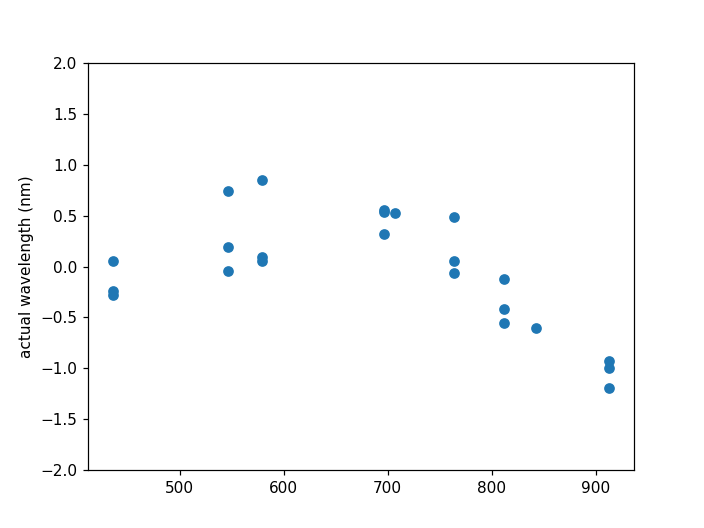

Text(0,0.5,'actual wavelength (nm)')

In [478]:
kwargs = dict(
    px=dispersion_data[:,2], 
    n0=n0,
    wl_center=dispersion_data[:,1],
    m_order=1,
    d_grating=1/150.*1e6, # nm
    x_pixel=16e3, #nm
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    offset_adjust = 0.,
    curvature = result.x[3]
)
plt.figure(3)
plt.plot(dispersion_data[:,0],wl_p_calib_p2(**kwargs) - dispersion_data[:,0],'o')
plt.ylim(-2,2)
plt.ylabel('deviation (nm)')
plt.ylabel('actual wavelength (nm)')

In [462]:
# to store for ini file
# f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature
Y = 'f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature'.split(', ')
str([ kwargs[x] for x in Y ])
#kwargs

'[298999999.88858783, 0.0053642276254824888, 0.86096137384084359, 266.82000000000005, 0.0, 6666.666666666667, 16000.0, 9.2129430641511266e-06]'

# Andor grating 3 (1200 g/mm) 05 Dec 2018, focus 295 steps

<IPython.core.display.Javascript object>


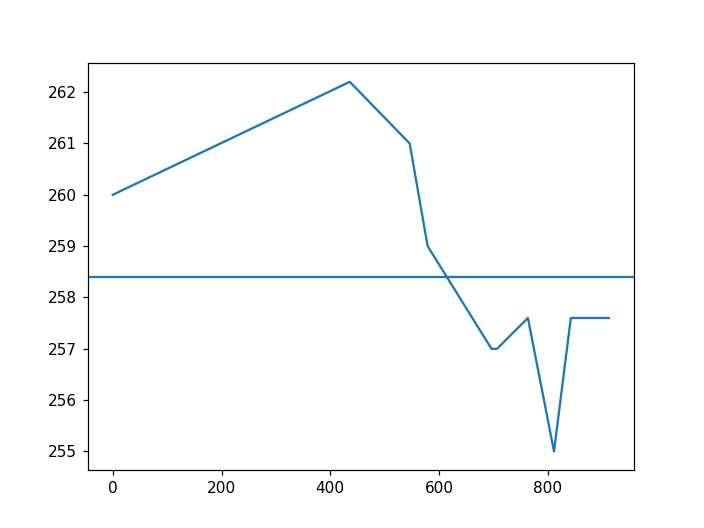

In [509]:
# Camera focus = 295 steps
wl_center_data = np.array([
# center_wl, pixel of peak
[0,     260],
[435.833, 262.2],
[546.074, 261.],
[579.066, 259],
[696.543, 257],
[706.722, 257],
[763.511, 257.6],
[811.532, 255.],
[842.465, 257.6],
[912.297, 257.6],    
])
    
n0 = np.mean(wl_center_data[:,1])
n0    
plt.figure(6)
plt.plot(wl_center_data[:,0], wl_center_data[:,1])
plt.axhline(n0)

In [510]:
dispersion_data = np.array([
#wl_actual, wl_center, pixel
[435.833, 428, 476.56],
[435.833, 442, 93.5],

[579.066, 572, 465.1],
[579.066, 586, 55.5],

[696.543, 689, 488.45],
[696.543, 703, 57.08],

[811.532, 804, 501.3],
[811.532, 818, 46.8],

[763.511, 756, 494.06],
[763.511, 770, 53.5],

[912.297, 907, 441.6],
[912.297, 918, 54.38],
    
[435.833,435.833, 262.2],
[546.074,546.074, 261.],
[579.066,579.066, 259],
[696.543,696.543, 257],
[706.722,706.722, 257],
[763.511,763.511, 257.6],
[811.532,811.532, 255.],
[842.465,842.465, 257.6],
[912.297,912.297, 257.6]  
])

In [511]:
initial_guess = (3e8,0.0,0.1,0)  #  (f, delta, gamma, curvature)
bounds = ([2.98e8,-np.inf,-np.inf,-0.1],[3.02e8,np.inf,np.inf,0.1])
kwargs = dict(
    px=dispersion_data[:,2], 
    n0=n0,
    wl_center=dispersion_data[:,1], # nm
    m_order=1,
    d_grating=1/1200.*1e6, # nm
    x_pixel=16e3, #nm
    wl_actual=dispersion_data[:,0], # nm
    offset_adjust = 0.
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs,method='trf',bounds=bounds,xtol = 1e-12, gtol = 1e-12)
result.x

array([  2.98000000e+08,   4.34156151e-01,   3.93278583e-01,
         1.39156592e-06])

<IPython.core.display.Javascript object>


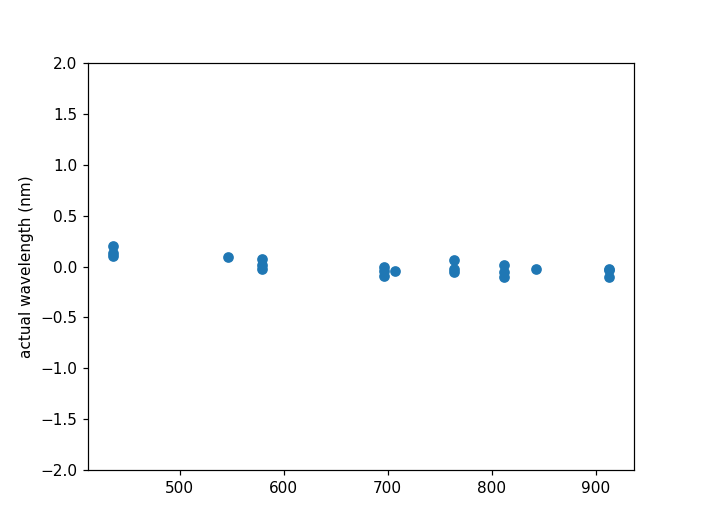

Text(0,0.5,'actual wavelength (nm)')

In [512]:
kwargs = dict(
    px=dispersion_data[:,2], 
    n0=n0,
    wl_center=dispersion_data[:,1],
    m_order=1,
    d_grating=1/1200.*1e6, # nm
    x_pixel=16e3, #nm
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    offset_adjust = 0.,
    curvature = result.x[3]
)
plt.figure(7)
plt.plot(dispersion_data[:,0],wl_p_calib_p2(**kwargs) - dispersion_data[:,0],'o')
plt.ylim(-2,2)
plt.ylabel('deviation (nm)')
plt.ylabel('actual wavelength (nm)')

In [513]:
# to store for ini file
# f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature
Y = 'f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature'.split(', ')
str([ kwargs[x] for x in Y ])
#kwargs

'[298000000.00000006, 0.43415615088652859, 0.39327858281634981, 258.39999999999998, 0.0, 833.3333333333334, 16000.0, 1.39156592263528e-06]'